<a href="https://colab.research.google.com/github/purple29th/Flixter/blob/master/Standard_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the directory structure
os.makedirs("results/models/standard_autoencoder", exist_ok=True)
os.makedirs("results/visualizations", exist_ok=True)

# Hyperparameters
input_shape = (1, 28, 28)  # MNIST image size
latent_dim = 128  # Increased latent dimension
learning_rate = 0.0005  # Adjusted learning rate
batch_size = 64
epochs = 10  # Increased epochs
epsilon = 0.0  # Adjusted epsilon

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 32, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# FGSM Attack Function
def fgsm_attack(image, epsilon, data_grad):
    if epsilon == 0:
        return image  # No perturbation applied
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)  # Clip to normalized range.
    return perturbed_image

# Function to denormalize images for visualization
def denormalize(image):
    return image * 0.3081 + 0.1307  # Reverse normalization for MNIST

# Function to visualize examples with more details
def visualize_examples(data, adv_data, clean_reconst, adv_reconst, clean_errors, adv_errors, clean_losses, adv_losses, indices_to_show):
    num_examples = len(indices_to_show)
    num_cols = 6  # Number of columns per data instance (original, adversarial, clean recon, adv recon, clean error, adv error)
    num_rows = num_examples  # Number of rows (one per data instance)

    plt.figure(figsize=(20, 4 * num_rows))  # Adjust figure size based on number of rows
    for i, idx in enumerate(indices_to_show):
        # Original Image
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        plt.imshow(denormalize(data[idx].squeeze(0).cpu().numpy()), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Adversarial Image
        plt.subplot(num_rows, num_cols, i * num_cols + 2)
        plt.imshow(denormalize(adv_data[idx].squeeze(0).cpu().numpy()), cmap="gray")
        plt.title(f"Adversarial (ε={epsilon})")
        plt.axis("off")

        # Reconstructed Clean Image
        plt.subplot(num_rows, num_cols, i * num_cols + 3)
        plt.imshow(denormalize(clean_reconst[idx].squeeze(0).cpu().numpy()), cmap="gray")
        plt.title(f"Reconstructed (Clean)\nLoss: {clean_losses[idx]:.4f}")
        plt.axis("off")

        # Reconstructed Adversarial Image
        plt.subplot(num_rows, num_cols, i * num_cols + 4)
        plt.imshow(denormalize(adv_reconst[idx].squeeze(0).cpu().numpy()), cmap="gray")
        plt.title(f"Reconstructed (Adv)\nLoss: {adv_losses[idx]:.4f}")
        plt.axis("off")

        # Error Map (Clean)
        plt.subplot(num_rows, num_cols, i * num_cols + 5)
        error_map_clean = clean_errors[idx].squeeze().cpu().numpy()
        plt.imshow(error_map_clean, cmap="hot", vmin=0, vmax=clean_errors.max())  # Dynamic scaling
        plt.colorbar()
        plt.title(f"Error Map (Clean)\nMax: {error_map_clean.max():.4f}\nMin: {error_map_clean.min():.4f}")
        plt.axis("off")

        # Error Map (Adversarial)
        plt.subplot(num_rows, num_cols, i * num_cols + 6)
        error_map_adv = adv_errors[idx].squeeze().cpu().numpy()
        plt.imshow(error_map_adv, cmap="hot", vmin=0, vmax=adv_errors.max())  # Dynamic scaling
        plt.colorbar()
        plt.title(f"Error Map (Adv)\nMax: {error_map_adv.max():.4f}\nMin: {error_map_adv.min():.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("results/visualizations/comparison.png")
    plt.show()

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructed = model(data)
        loss = criterion(reconstructed, data)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "results/models/standard_autoencoder/model_weights.pth")

print("Training completed! Model weights saved.")



KeyboardInterrupt: 

In [13]:
# Reinitialize the model with the correct latent dimension
latent_dim = 128  # Ensure this matches the saved model
model = ConvAutoencoder(latent_dim).to(device)

In [14]:
# Load the state dictionary with strict=False
model.load_state_dict(torch.load("results/models/standard_autoencoder/model_weights.pth", map_location=device), strict=False)
model.eval()  # Set the model to evaluation mode

<ipython-input-14-e6554692fa69>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/models/standard_autoencoder/model_weights.pth", ma

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=128, bias=True)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=1568, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [21]:
epsilon = 0.0

<ipython-input-22-8d6b91bc7a5e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/models/standard_autoencoder/model_weights.pth", ma

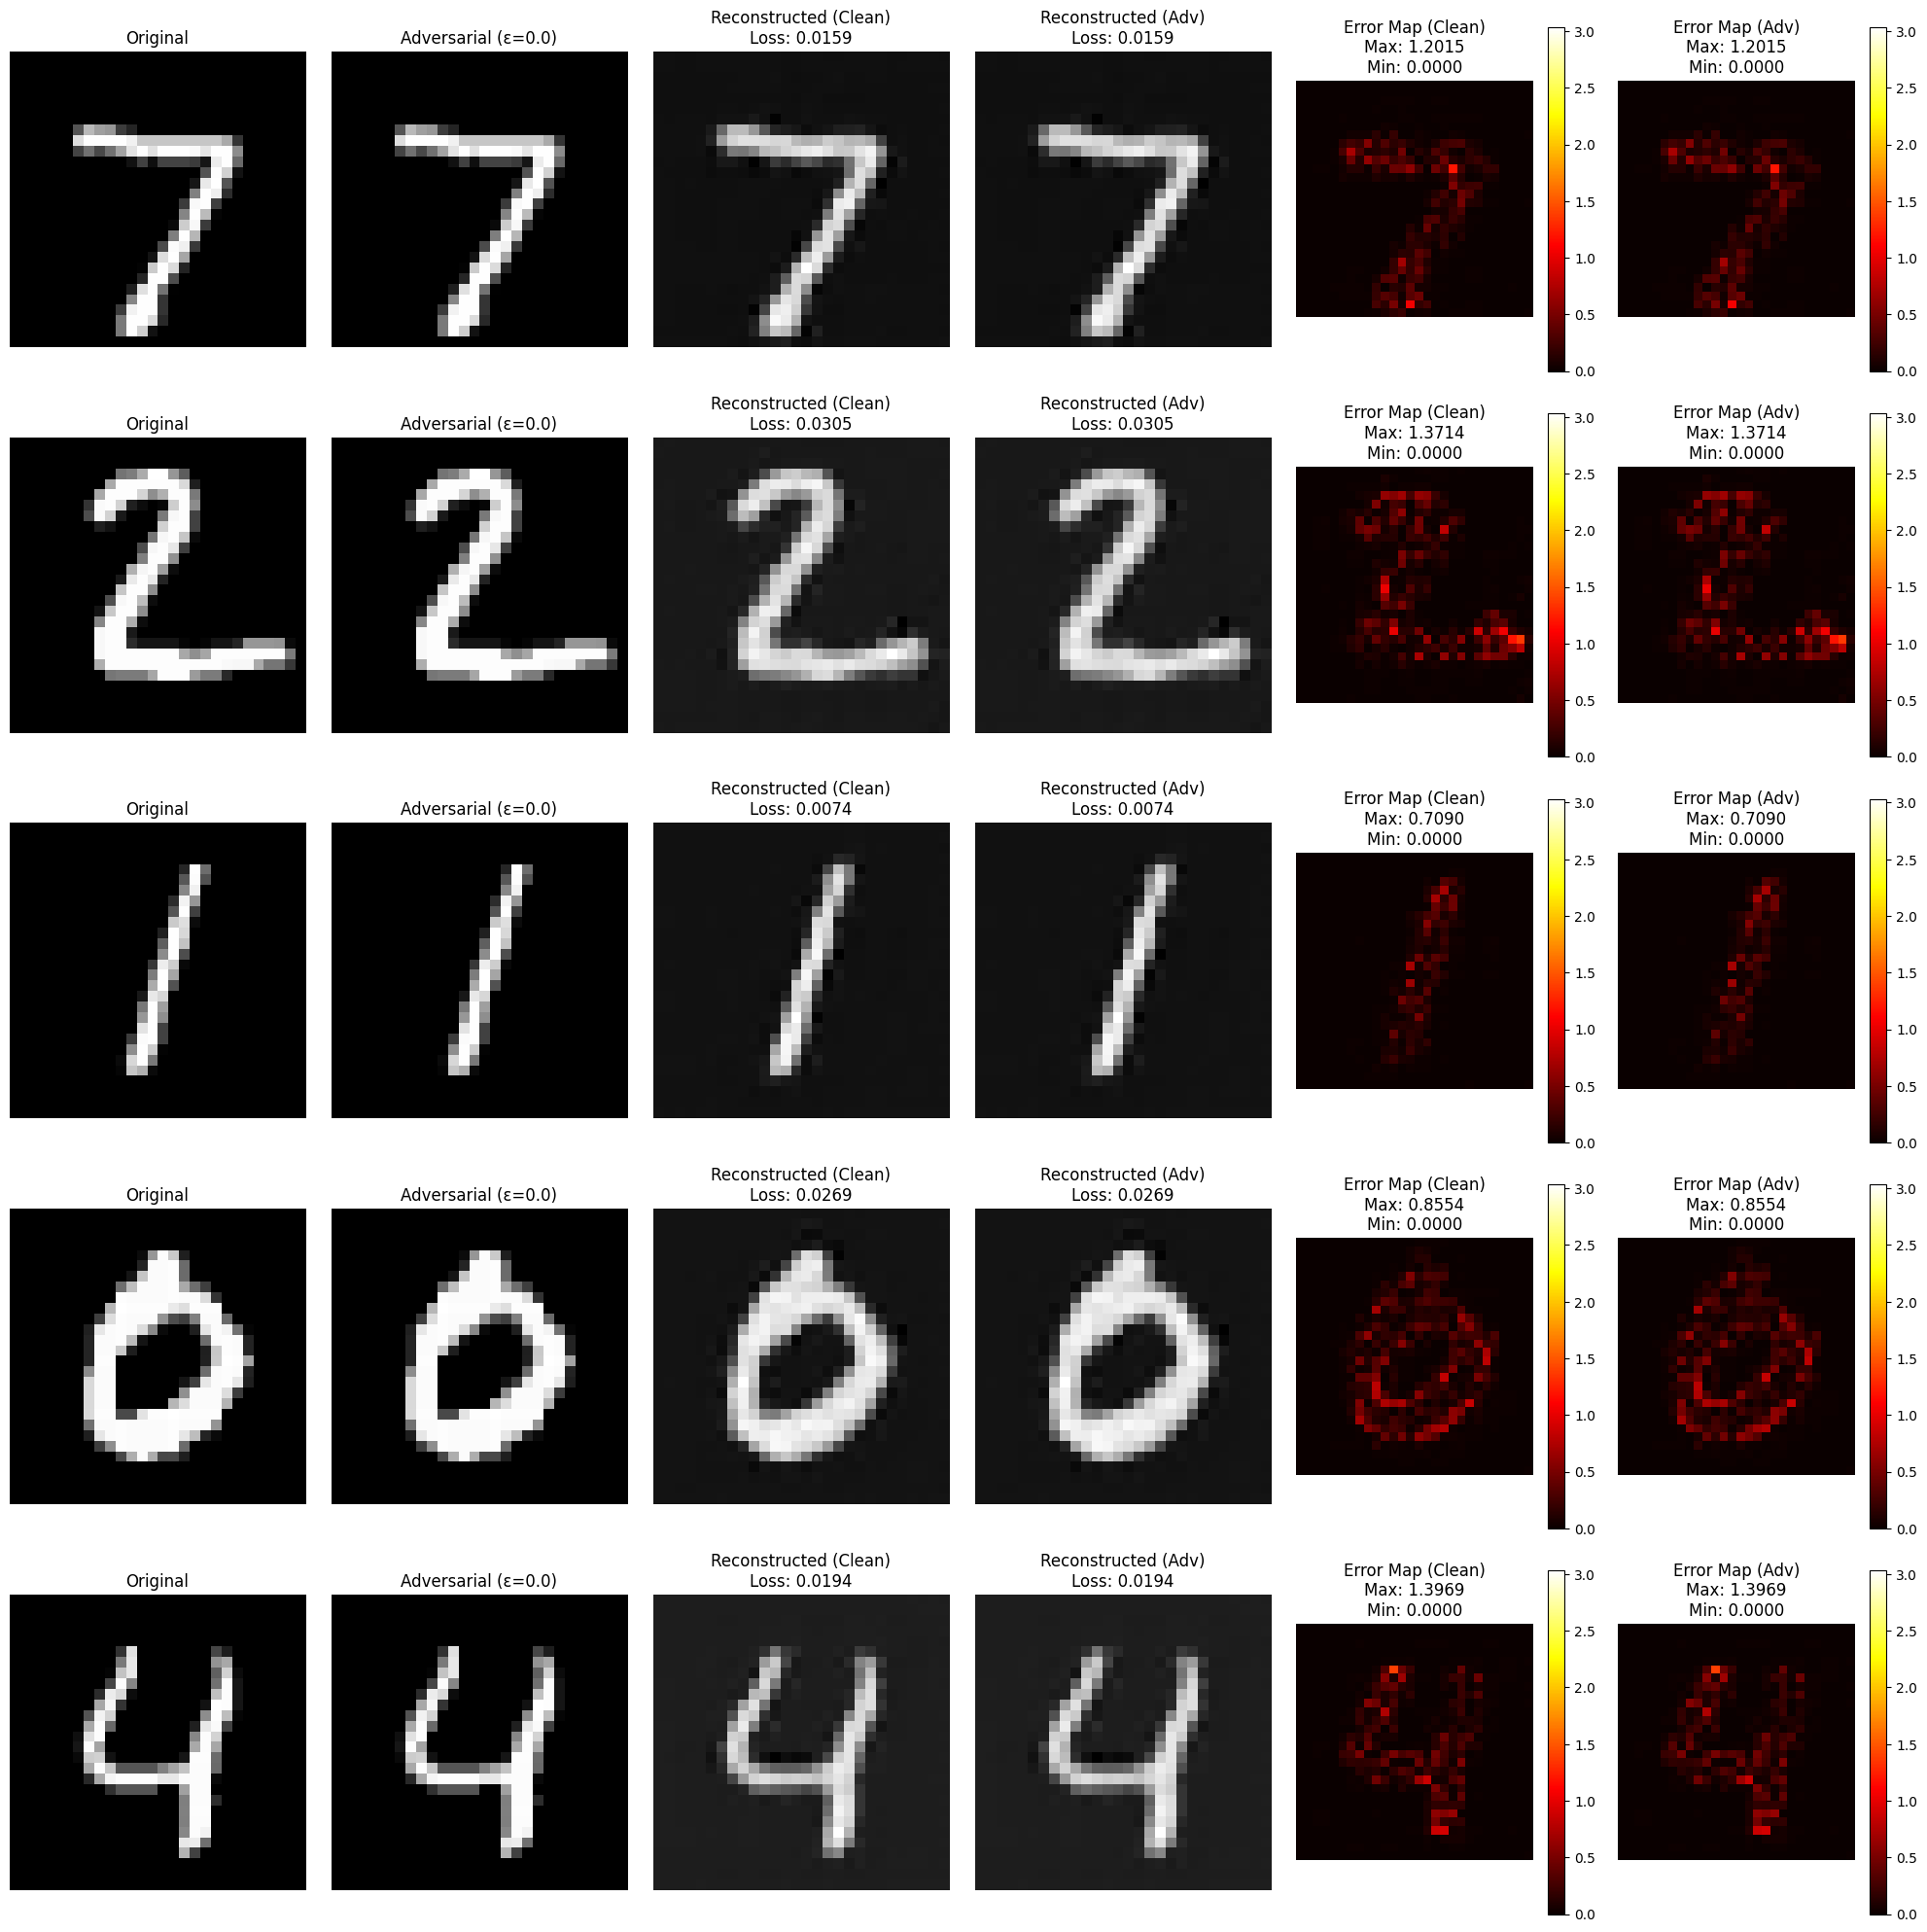

Testing and visualization completed! Check the 'results/visualizations' folder for outputs.


In [22]:
# Define the loss function with reduction='none'
criterion = nn.MSELoss(reduction='none')

# Load the trained model
model.load_state_dict(torch.load("results/models/standard_autoencoder/model_weights.pth", map_location=device), strict=False)
model.eval()  # Set the model to evaluation mode

# Test the model and generate adversarial examples
clean_images = []
adv_images = []
clean_reconstructions = []
adv_reconstructions = []
clean_errors = []
adv_errors = []
clean_losses = []
adv_losses = []

for batch_idx, (data, _) in enumerate(test_loader):
    data = data.to(device)
    data.requires_grad = True  # Enable gradient computation for FGSM

    # Get clean reconstruction
    reconstructed = model(data)

    # Compute per-pixel loss
    per_pixel_loss = criterion(reconstructed, data)  # Shape: (batch_size, channels, height, width)

    # Compute mean loss over spatial dimensions (height, width) for each image in the batch
    loss = per_pixel_loss.mean(dim=(1, 2, 3))  # Shape: (batch_size,)
    loss.mean().backward()  # Backpropagate the mean loss

    # Generate adversarial examples
    perturbed_data = fgsm_attack(data, epsilon, data.grad.data)

    # Get adversarial reconstruction
    adv_reconstructed = model(perturbed_data).detach()
    adv_per_pixel_loss = criterion(adv_reconstructed, perturbed_data)  # Shape: (batch_size, channels, height, width)
    adv_loss = adv_per_pixel_loss.mean(dim=(1, 2, 3))  # Shape: (batch_size,)

    # Save results for visualization
    clean_images.append(data.detach().cpu())
    adv_images.append(perturbed_data.detach().cpu())
    clean_reconstructions.append(reconstructed.detach().cpu())
    adv_reconstructions.append(adv_reconstructed.cpu())
    clean_errors.append(torch.abs(data - reconstructed).detach().cpu())
    adv_errors.append(torch.abs(perturbed_data - adv_reconstructed).detach().cpu())
    clean_losses.append(loss.detach().cpu())
    adv_losses.append(adv_loss.detach().cpu())

    if batch_idx == 0:  # Only process the first batch for visualization
        break

# Concatenate results
clean_images = torch.cat(clean_images)
adv_images = torch.cat(adv_images)
clean_reconstructions = torch.cat(clean_reconstructions)
adv_reconstructions = torch.cat(adv_reconstructions)
clean_errors = torch.cat(clean_errors)
adv_errors = torch.cat(adv_errors)
clean_losses = torch.cat(clean_losses)
adv_losses = torch.cat(adv_losses)

# Modify indices_to_show based on batch size
num_examples = min(5, len(clean_images))
indices_to_show = list(range(num_examples))

# Visualize examples with more details
visualize_examples(clean_images, adv_images, clean_reconstructions, adv_reconstructions, clean_errors, adv_errors, clean_losses, adv_losses, indices_to_show=indices_to_show)

print("Testing and visualization completed! Check the 'results/visualizations' folder for outputs.")